<a href="https://colab.research.google.com/github/duke-sunshine/Algorithmic-Trading-Finance/blob/main/Session_2_Simple_Moving_Average_Rule_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Data 
1.   Install the Alpha Vantage API
2.   [Claim your own API Key](https://www.alphavantage.co/support/#api-key)
3.   [Import data from Time Series Stock APIs by specifiying API key and Parameters](https://www.alphavantage.co/documentation/)

Install Alpha Vantage Package

In [ ]:
pip install alpha_vantage

In [ ]:
from alpha_vantage.timeseries import TimeSeries
API_key = 'RY5PVLL8EDHDRLEG'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import pandas_datareader as web

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Program import data class

In [ ]:
class Data:
  def __init__(self,API_key, symbol, interval):
    self.API_key = API_key
    self.symbol = symbol
    self.interval = interval
  def import_data(self):
    ts = TimeSeries(key=self.API_key, output_format='pandas')
    data=ts.get_intraday(self.symbol, interval = self.interval, outputsize = 'full') # We use 5-min interval to determine the time when traders make investment decisions.
    data[0].rename(columns={'1. open':'open', '2. high':'high', '3. low':'low', '4. close':'close', '5. volume':'volume'}, inplace = True)
    df = data[0]
    return df

return data with specified API and parameters: 

we use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.  

In [ ]:
TSLA=Data('RY5PVLL8EDHDRLEG','TSLA','5min')
df_TSLA=TSLA.import_data()
df_TSLA.sort_index(ascending=True, inplace=True)
df_TSLA.head()

,open,high,low,close,volume
date,,,,,
2021-07-26 04:05:00,645.60,645.60,640.15,641.00,7185.0
2021-07-26 04:10:00,640.43,640.43,639.63,640.00,4420.0
2021-07-26 04:20:00,640.46,640.46,640.00,640.35,2261.0
2021-07-26 04:25:00,639.95,639.95,639.95,639.95,349.0
2021-07-26 04:30:00,640.30,640.30,640.00,640.00,1045.0


In [ ]:
AAPL=Data('RY5PVLL8EDHDRLEG','AAPL','5min')
df_AAPL=AAPL.import_data()
df_AAPL.sort_index(ascending=True, inplace=True)
df_AAPL.head()

,open,high,low,close,volume
date,,,,,
2021-07-26 04:05:00,148.1270,148.1270,147.6178,147.6178,13746.0
2021-07-26 04:10:00,147.5778,147.6377,147.1784,147.2084,21170.0
2021-07-26 04:15:00,147.2184,147.2783,147.1884,147.2783,9297.0
2021-07-26 04:20:00,147.2284,147.3082,147.2084,147.2783,13479.0
2021-07-26 04:25:00,147.2883,147.4480,147.2883,147.4480,5043.0


# 2. Build Neural Network

LSTM stands for Long Short-Term Memory Model, which is able to store information over a period of time, and [Liu et al's (2018)](https://ieeexplore.ieee.org/abstract/document/8398183) paper shows that the LSTM recurrent neural networks is able to filter and extract feature value and analyze the stock data, thus we use this colab to set up the the prediction model of the corresponding stock transaction. We also get inspiration from [Sang and Di Pierro's paper (2019)](https://doi.org/10.1016/j.jfds.2018.10.003) to make a comparison of Return on Investment (RoI) with traditional Simple Moving Average (SMA) Strategy. The pure SMA strategy over trading on two stocks is implemented in [Session 1](https://colab.research.google.com/drive/1KgtvSVkbG4_wAzOMOYAtogS18sDcGekG?usp=sharing).


First preprocess the data by separating them from data training and testing group for preparation.

In [ ]:
class data_cleaning:
  def __init__(self, dataset):
    self.dataset = dataset
  def data_training(self):
    num = int(3/5 * self.dataset.shape[0])
    training = self.dataset.iloc[:num].copy()
    return training
  def data_testing(self):
    num = int(3/5 * self.dataset.shape[0])
    testing = self.dataset.iloc[num:].copy() 
    predict_date = testing.index
    return testing, predict_date

In [ ]:
TSLA_cleaning = data_cleaning(df_TSLA)
TSLA_training = TSLA_cleaning.data_training()
TSLA_training

,open,high,low,close,volume
date,,,,,
2021-07-26 04:05:00,645.60,645.60,640.15,641.00,7185.0
2021-07-26 04:10:00,640.43,640.43,639.63,640.00,4420.0
2021-07-26 04:20:00,640.46,640.46,640.00,640.35,2261.0
2021-07-26 04:25:00,639.95,639.95,639.95,639.95,349.0
2021-07-26 04:30:00,640.30,640.30,640.00,640.00,1045.0
...,...,...,...,...,...
2021-08-10 18:40:00,709.09,709.09,709.09,709.09,812.0
2021-08-10 18:45:00,709.00,709.00,708.84,708.84,566.0
2021-08-10 18:50:00,709.05,709.05,709.05,709.05,1082.0


In [ ]:
TSLA_testing = TSLA_cleaning.data_testing()[0]
TSLA_testing

,open,high,low,close,volume
date,,,,,
2021-08-10 19:05:00,708.7900,709.00,708.7600,709.00,1090.0
2021-08-10 19:15:00,708.9900,709.00,708.8000,708.80,3608.0
2021-08-10 19:20:00,708.8000,708.99,708.5000,708.99,3402.0
2021-08-10 19:30:00,708.9000,708.90,708.7700,708.77,673.0
2021-08-10 19:35:00,708.7700,708.77,708.7000,708.70,1143.0
...,...,...,...,...,...
2021-08-20 19:40:00,679.9999,680.00,679.9999,680.00,590.0
2021-08-20 19:45:00,679.9000,679.90,679.8000,679.80,1444.0
2021-08-20 19:50:00,679.9000,680.00,679.9000,680.00,1039.0


In [ ]:
TSLA_predict_date = TSLA_cleaning.data_testing()[1]
TSLA_predict_date

DatetimeIndex(['2021-08-10 19:05:00', '2021-08-10 19:15:00',
               '2021-08-10 19:20:00', '2021-08-10 19:30:00',
               '2021-08-10 19:35:00', '2021-08-10 19:40:00',
               '2021-08-10 19:50:00', '2021-08-10 19:55:00',
               '2021-08-10 20:00:00', '2021-08-11 04:10:00',
               ...
               '2021-08-20 19:15:00', '2021-08-20 19:20:00',
               '2021-08-20 19:25:00', '2021-08-20 19:30:00',
               '2021-08-20 19:35:00', '2021-08-20 19:40:00',
               '2021-08-20 19:45:00', '2021-08-20 19:50:00',
               '2021-08-20 19:55:00', '2021-08-20 20:00:00'],
              dtype='datetime64[ns]', name='date', length=1408, freq=None)

In [ ]:
AAPL_cleaning = data_cleaning(df_AAPL)
AAPL_training = AAPL_cleaning.data_training()
AAPL_training

,open,high,low,close,volume
date,,,,,
2021-07-26 04:05:00,148.1270,148.1270,147.6178,147.6178,13746.0
2021-07-26 04:10:00,147.5778,147.6377,147.1784,147.2084,21170.0
2021-07-26 04:15:00,147.2184,147.2783,147.1884,147.2783,9297.0
2021-07-26 04:20:00,147.2284,147.3082,147.2084,147.2783,13479.0
2021-07-26 04:25:00,147.2883,147.4480,147.2883,147.4480,5043.0
...,...,...,...,...,...
2021-08-10 19:20:00,145.5700,145.5900,145.5500,145.5500,2281.0
2021-08-10 19:25:00,145.5500,145.5500,145.5500,145.5500,521.0
2021-08-10 19:30:00,145.5200,145.5500,145.5200,145.5500,2859.0


In [ ]:
AAPL_testing = AAPL_cleaning.data_testing()[0]
AAPL_testing

,open,high,low,close,volume
date,,,,,
2021-08-10 19:45:00,145.51,145.52,145.50,145.5000,5217.0
2021-08-10 19:50:00,145.52,145.52,145.51,145.5100,2152.0
2021-08-10 19:55:00,145.52,145.60,145.52,145.6000,4384.0
2021-08-10 20:00:00,145.62,145.66,145.60,145.6000,7082.0
2021-08-11 04:05:00,145.41,145.41,145.41,145.4100,1090.0
...,...,...,...,...,...
2021-08-20 19:40:00,148.24,148.24,148.23,148.2300,1124.0
2021-08-20 19:45:00,148.23,148.25,148.23,148.2401,1599.0
2021-08-20 19:50:00,148.24,148.25,148.20,148.2200,3782.0


In [ ]:
AAPL_predict_date = AAPL_cleaning.data_testing()[1]
AAPL_predict_date

DatetimeIndex(['2021-08-10 19:45:00', '2021-08-10 19:50:00',
               '2021-08-10 19:55:00', '2021-08-10 20:00:00',
               '2021-08-11 04:05:00', '2021-08-11 04:10:00',
               '2021-08-11 04:15:00', '2021-08-11 04:20:00',
               '2021-08-11 04:25:00', '2021-08-11 04:30:00',
               ...
               '2021-08-20 19:15:00', '2021-08-20 19:20:00',
               '2021-08-20 19:25:00', '2021-08-20 19:30:00',
               '2021-08-20 19:35:00', '2021-08-20 19:40:00',
               '2021-08-20 19:45:00', '2021-08-20 19:50:00',
               '2021-08-20 19:55:00', '2021-08-20 20:00:00'],
              dtype='datetime64[ns]', name='date', length=1466, freq=None)

Then we build the LSTM Neural Network to create datasets by LSTM Neural Network's prediction, and plot the actual and predicted price respectively.

In [ ]:
class Stock_LSTM:
  def __init__(self, dataset1, dataset2, topic, predict_date):
    self.dataset1 = dataset1
    self.dataset2 = dataset2
    self.topic = topic
    self.predict_date = predict_date
  def build(self):
    scalar = MinMaxScaler()
    
    #use your training data to change the dataset1 one
    data_training_scaled = scalar.fit_transform(self.dataset1)
    X_train = []
    y_train = []
    for i in range(60, self.dataset1.shape[0]):
      X_train.append(data_training_scaled[i-60: i])
      y_train.append(data_training_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
  
    regressor = Sequential()

    regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    regressor.add(Dropout(0.3))

    regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    regressor.add(Dropout(0.4))

    regressor.add(LSTM(units = 120, activation = 'relu'))
    regressor.add(Dropout(0.5))

    regressor.add(Dense(units = 1))
    regressor.summary()
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

    past_60 = self.dataset2.tail(60)
    dt = past_60.append(self.dataset2, ignore_index = True)
    inputs = scalar.fit_transform(dt)
    X_test = []
    y_test = []

    for i in range(60, inputs.shape[0]):
      X_test.append(inputs[i-60:i])
      y_test.append(inputs[i, 0])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    y_pred = regressor.predict(X_test)
    
    #scale = 1/scalar.scale_[0]
    scale = 97.54
    y_pred = y_pred*scale
    y_test = y_test*scale
    
    y_pred = pd.DataFrame(y_pred, index = self.predict_date)
    y_test = pd.DataFrame(y_test, index = self.predict_date)
    
    plt.figure(figsize=(28,12))
    plt.plot(y_test, color = 'red', label = self.topic + ' Price')
    plt.plot(y_pred, color = 'blue', label = 'Predicted ' + self.topic + ' Price')
    plt.title(self.topic + ' Price Prediction - After 50 epochs and Batch Size = 64')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    return y_pred
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

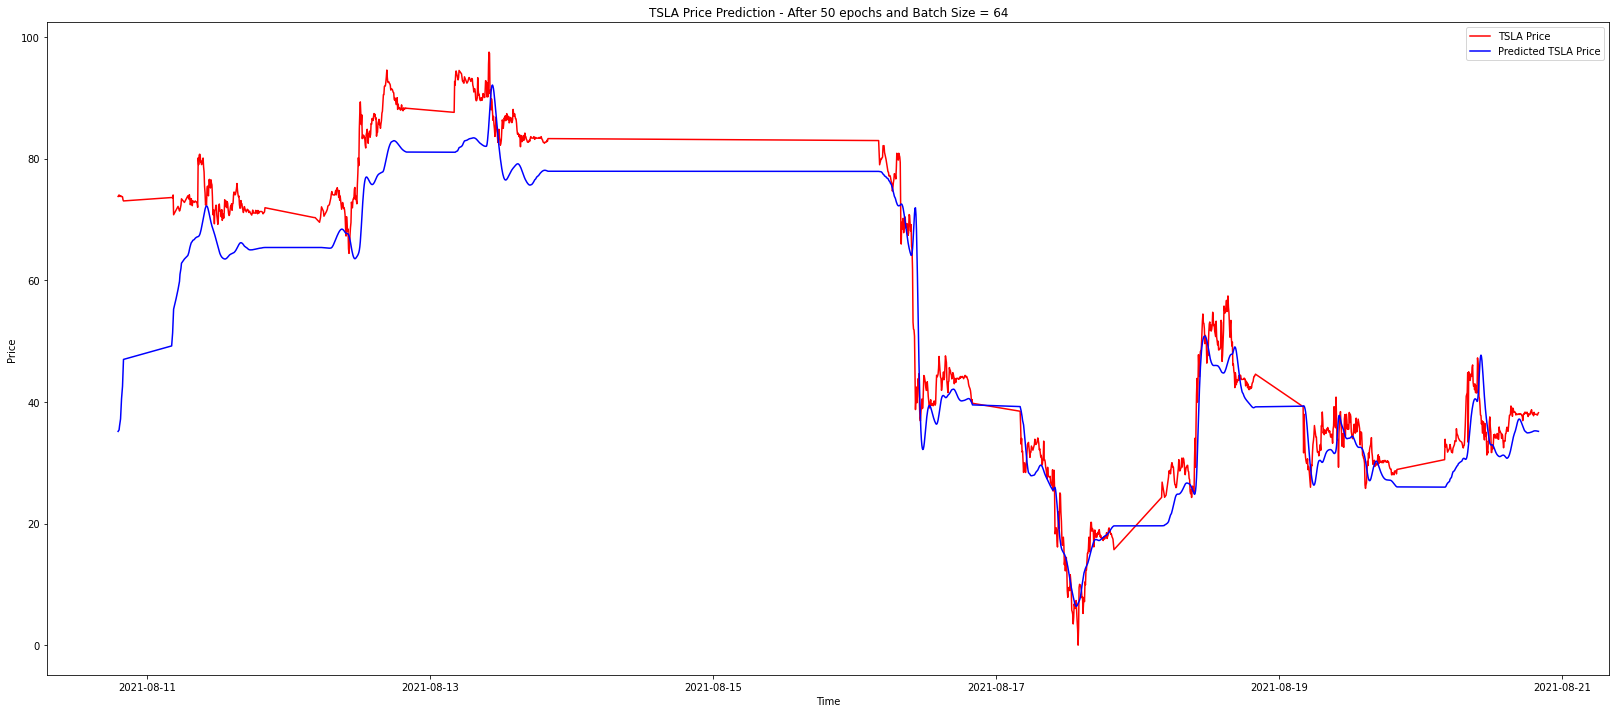

,0
date,
2021-08-10 19:05:00,35.153606
2021-08-10 19:15:00,35.408604
2021-08-10 19:20:00,36.087307
2021-08-10 19:30:00,37.203178
2021-08-10 19:35:00,38.704628
...,...
2021-08-20 19:40:00,35.234070
2021-08-20 19:45:00,35.220802
2021-08-20 19:50:00,35.204533


In [ ]:
TSLA_LSTM = Stock_LSTM(TSLA_training,TSLA_testing,'TSLA', TSLA_predict_date)
TSLA_LSTM_data = TSLA_LSTM.build()
TSLA_LSTM_data

In [ ]:
df_predict_TSLA = TSLA_LSTM_data.set_axis(['close'], axis=1, inplace=False)
df_predict_TSLA

,close
date,
2021-08-10 19:05:00,35.153606
2021-08-10 19:15:00,35.408604
2021-08-10 19:20:00,36.087307
2021-08-10 19:30:00,37.203178
2021-08-10 19:35:00,38.704628
...,...
2021-08-20 19:40:00,35.234070
2021-08-20 19:45:00,35.220802
2021-08-20 19:50:00,35.204533


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)              

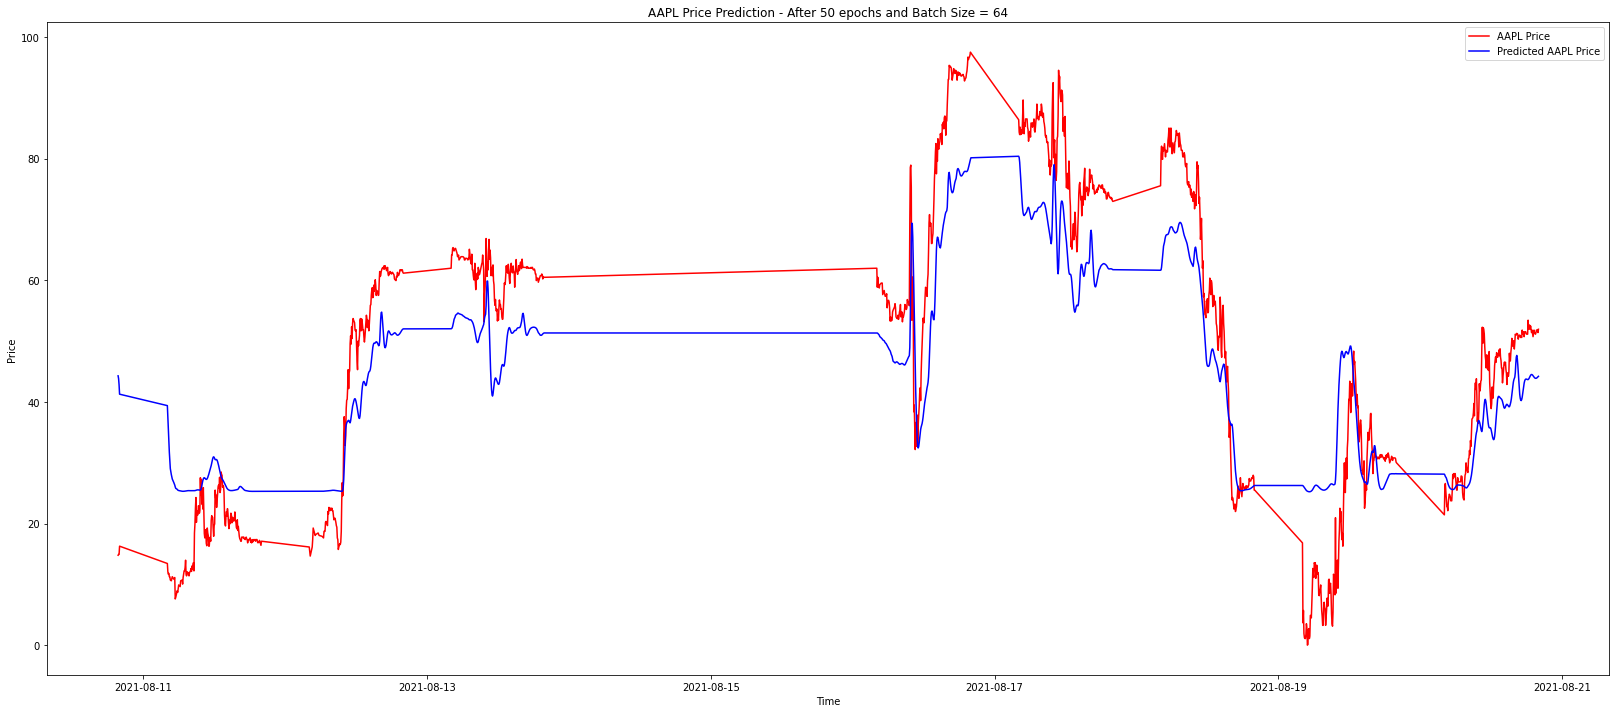

,0
date,
2021-08-10 19:45:00,44.298325
2021-08-10 19:50:00,43.841190
2021-08-10 19:55:00,42.813396
2021-08-10 20:00:00,41.279091
2021-08-11 04:05:00,39.398544
...,...
2021-08-20 19:40:00,43.918022
2021-08-20 19:45:00,43.975643
2021-08-20 19:50:00,44.057152


In [ ]:
AAPL_LSTM = Stock_LSTM(AAPL_training,AAPL_testing,'AAPL',AAPL_predict_date)
AAPL_LSTM_data = AAPL_LSTM.build()
AAPL_LSTM_data

In [ ]:
df_predict_AAPL = AAPL_LSTM_data.set_axis(['close'], axis=1, inplace=False)
df_predict_AAPL

,close
date,
2021-08-10 19:45:00,44.298325
2021-08-10 19:50:00,43.841190
2021-08-10 19:55:00,42.813396
2021-08-10 20:00:00,41.279091
2021-08-11 04:05:00,39.398544
...,...
2021-08-20 19:40:00,43.918022
2021-08-20 19:45:00,43.975643
2021-08-20 19:50:00,44.057152


# 3. Generate buy and sell signals with Visualizations

Program the signal class

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

The Simple moving average with window $n$ at time $t$:

$SMA_t^n=\frac{1}{n}\sum_{i=t-n+1}^{t}p_i$

In [ ]:
class signal:
  def __init__(self, data, short_window, long_window):
    self.data = data
    self.short_window = short_window
    self.long_window = long_window
  def signals(self):
    signals = pd.DataFrame(index=self.data.index)
    signals = signals.sort_values(by='date')
    signals['signal'] = 0.0
    signals['short_ma'] = self.data['close'].rolling(window=self.short_window, min_periods=self.short_window, center=True, closed='right').mean()
    signals['long_ma'] = self.data['close'].rolling(window=self.long_window, min_periods=self.long_window, center=True, closed='right').mean()  
    signals['signal'][self.short_window:] = np.where(signals['short_ma'][self.short_window:]>signals['long_ma'][self.short_window:], 1.0, 0.0)     
    signals['positions'] = signals['signal'].diff()
    signals = signals.dropna()
    return signals

Return signals with input data and short and long windows. 

We use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.

Short_window = 5

Long_window = 10

Initially, we utilize one of the simplest yet most effective ways to filter the signal, the Simple Moving Average S.M.A., calculated by summing up the prices of
instrument closure over a certain number of single periods (for instance, 15 minute samples, 30 minutes samples, 1 hour samples, etc). This value is then divided by the number of such periods. In [Kablan and Falzon's paper](doi.org/10.5281/zenodo.1328892) and [Silva et al's IEEE Paper](10.1109/IJCNN.2014.6889835), they suggest to choose 5-min and 10-min as the short and long window for the crossover simulation.

In [ ]:
SMA_predict_TSLA = signal(df_predict_TSLA, 5, 10)
SMA_predict_TSLA

In [ ]:
Signal_predict_TSLA = SMA_predict_TSLA.signals()
Signal_predict_TSLA.head()

,signal,short_ma,long_ma,positions
date,,,,
2021-08-10 19:40:00,1.0,40.750436,40.661689,1.0
2021-08-10 19:50:00,1.0,42.709496,42.282145,0.0
2021-08-10 19:55:00,1.0,44.811913,44.079572,0.0
2021-08-10 20:00:00,1.0,46.980214,45.997158,0.0
2021-08-11 04:10:00,1.0,49.143055,47.974205,0.0


In [ ]:
SMA_predict_AAPL = signal(df_predict_AAPL, 5, 10)
SMA_predict_AAPL

In [ ]:
Signal_predict_AAPL = SMA_predict_AAPL.signals()
Signal_predict_AAPL.head()

,signal,short_ma,long_ma,positions
date,,,,
2021-08-11 04:10:00,0.0,37.374863,37.984670,0.0
2021-08-11 04:15:00,0.0,35.468493,36.459527,0.0
2021-08-11 04:20:00,0.0,33.643231,34.882600,0.0
2021-08-11 04:25:00,0.0,31.976343,33.333583,0.0
2021-08-11 04:30:00,0.0,30.518384,31.881322,0.0


Define signal visualization class

In [ ]:
class signal_figure:
  def __init__(self, prices, signals, topic):
    self.prices = prices
    self.signals = signals
    self.topic = topic
  def signal_figure(self):
    close = self.prices['close']
    close = close.to_frame()
    close = close.merge(self.signals,how='inner',left_index=True, right_index=True)
    close = close.sort_values(by='date')
    fig = plt.figure(figsize = (18,8))
    plt.plot(close.close, color='g', lw=1., label = 'Stock Price')
    plt.plot(close.short_ma, color='r', lw=1., label = 'Short Window Moving Average')
    plt.plot(close.long_ma, color='b', lw=1., label = 'Long Window Moving Average')
    plt.plot(close.loc[close.positions == 1.0].index, close.short_ma[close.positions == 1.0], '^', markersize=5, color='green',label = 'buying signal')
    plt.plot(close.loc[close.positions == -1.0].index, close.long_ma[close.positions == -1.0],'v', markersize=5, color='red',label = 'selling signal')
    plt.xlabel('Date')
    plt.ylabel('Dollars')
    plt.title(self.topic + ' Stock Price With Buying and Selling Signal Generated By SMA')
    plt.legend()
    plt.show()
    return close

Return plots with input data.

We use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.

Short_window = 5 

Long_window = 10

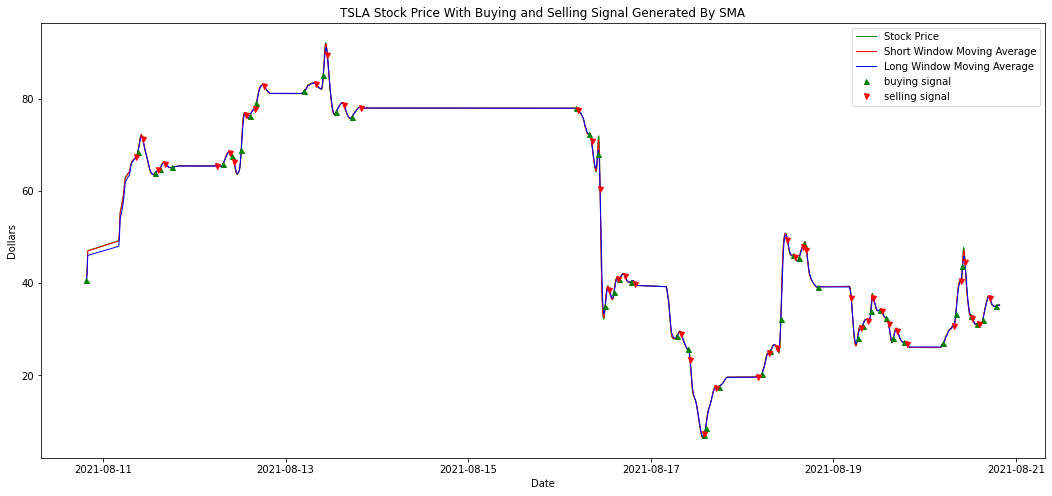

In [ ]:
SMA_predict_TSLA_Figure = signal_figure(df_predict_TSLA, Signal_predict_TSLA, 'TSLA')
SMA_Signal_predict_TSLA = SMA_predict_TSLA_Figure.signal_figure()

In [ ]:
SMA_Signal_predict_TSLA.head()

,close,signal,short_ma,long_ma,positions
date,,,,,
2021-08-10 19:40:00,40.516659,1.0,40.750436,40.661689,1.0
2021-08-10 19:50:00,42.568672,1.0,42.709496,42.282145,0.0
2021-08-10 19:55:00,44.759041,1.0,44.811913,44.079572,0.0
2021-08-10 20:00:00,46.998482,1.0,46.980214,45.997158,0.0
2021-08-11 04:10:00,49.216713,1.0,49.143055,47.974205,0.0


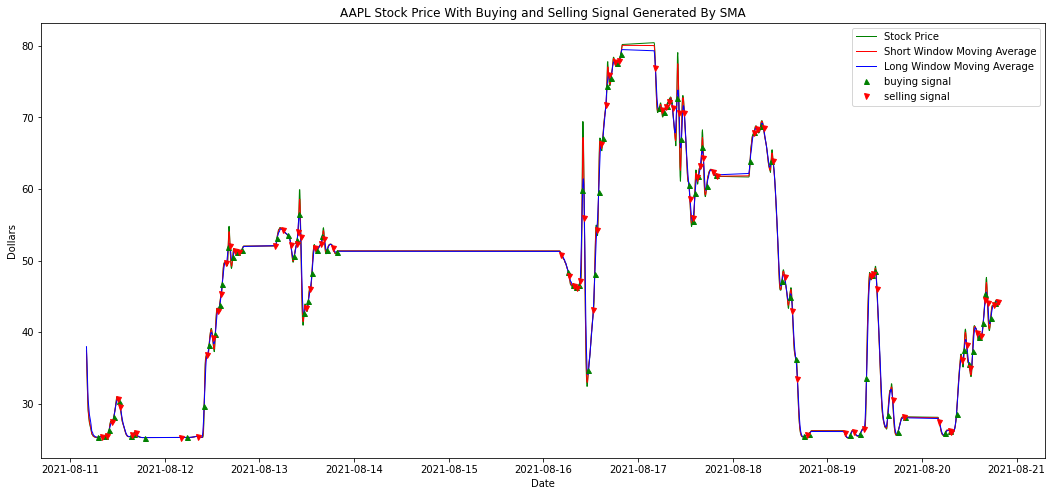

In [ ]:
SMA_predict_AAPL_Figure = signal_figure(df_predict_AAPL, Signal_predict_AAPL, 'AAPL')
SMA_Signal_predict_AAPL = SMA_predict_AAPL_Figure.signal_figure()

In [ ]:
SMA_Signal_predict_AAPL.head()

,close,signal,short_ma,long_ma,positions
date,,,,,
2021-08-11 04:10:00,37.381336,0.0,37.374863,37.984670,0.0
2021-08-11 04:15:00,35.361713,0.0,35.468493,36.459527,0.0
2021-08-11 04:20:00,33.453629,0.0,33.643231,34.882600,0.0
2021-08-11 04:25:00,31.747240,0.0,31.976343,33.333583,0.0
2021-08-11 04:30:00,30.272238,0.0,30.518384,31.881322,0.0


# 4. Generate Return of Investment and Portfolio Flows (cash, holding and total)

Program the portfolio class

In [ ]:
class portfolio:
  def __init__(self,data,topic,initial_capital=10000,max_buy=10000000,max_sell=10000000):
    self.data = data
    self.topic = topic
    self.initial_capital = initial_capital
    self.max_buy = max_buy
    self.max_sell = max_sell
  def portfolios(self):
    management = self.data
    prices = self.data['close']
    states = self.data['positions']
    states_buy = []
    states_sell = []
    cashes = []
    stocks = []
    holdings = []
    cash = self.initial_capital
    stock = 0
    holding = 0
    state = 0
    def buy(i,cash,stock,price):
      shares = cash // price #shares to buy in integer
      if shares<1:
        print('order %d: total cash %f, not enough to buy 1 share at price %f' % (i, cash, price))
      else:
        if shares>self.max_buy:
            buy_units = self.max_buy
        else:
            buy_units = shares
        cost = buy_units*price
        cash -= cost
        stock += buy_units
        holding = stock*price
        print('index %d: buy %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, buy_units, price, cash, stock, holding))
        return cash, stock, holding   
    def sell(i,cash, stock,price):
       if stock == 0:
         print('index %d: cannot sell anything, currentstock 0' % (i))
       else:
         if stock > self.max_sell:
            sell_units = self.max_sell
         else: 
            sell_units = stock
         stock -=sell_units
         revenue = sell_units*price
         cash += revenue
         holding = stock*price
         print('index %d: sell %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, sell_units, price, cash, stock, holding))
         return cash, stock, holding
    for i in range(0,management.shape[0]):
      
      state = states[i]
      price = prices[i]
      if state == 1:
        cash, stock, holding = buy(i, cash, stock, price)
        states_buy.append(i)
      elif state == -1:
        cash, stock, holding = sell(i,cash, stock, price)
      states_sell.append(i)
      cashes.append(cash)
      stocks.append(stock)
      holdings.append(holding)
    
    management['cash']=cashes
    management['stock']=stocks
    management['holding']=holdings
    management['total']=management['cash']+management['holding']
    management['roi']=(management['total']-self.initial_capital)/self.initial_capital
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
    ax1=management[['holding', 'cash', 'total']].plot(figsize=(14, 10),legend=True)
    ax1.set_title("Visualization of " + self.topic + " Portfolio Flows")
    ax2=management[['roi']].plot(figsize=(14, 10),legend=True)
    ax2.plot(management['roi'], label="Return on Investment", color='b')
    ax2.set_title(self.topic + " Return on Investment")

    return management

Return plots with input data.

We use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.

Short_window = 5 

Long_window = 10

index 0: buy 246 units at price 40.516659, current cash 32.901939, current stock 246.000000,current holding 9967.098061
index 32: sell 246 units at price 67.201256, current cash 16564.410866, current stock 0.000000,current holding 0.000000
index 38: buy 242 units at price 68.356873, current cash 22.047707, current stock 242.000000,current holding 16542.363159
index 54: sell 242 units at price 71.107819, current cash 17230.139809, current stock 0.000000,current holding 0.000000
index 92: buy 270 units at price 63.809898, current cash 1.467247, current stock 270.000000,current holding 17228.672562
index 103: sell 270 units at price 64.471771, current cash 17408.845482, current stock 0.000000,current holding 0.000000
index 107: buy 268 units at price 64.750923, current cash 55.598076, current stock 268.000000,current holding 17353.247406
index 124: sell 268 units at price 65.882790, current cash 17712.185692, current stock 0.000000,current holding 0.000000
index 140: buy 272 units at pric

,close,signal,short_ma,long_ma,positions,cash,stock,holding,total,roi
date,,,,,,,,,,
2021-08-10 19:40:00,40.516659,1.0,40.750436,40.661689,1.0,32.901939,246.0,9967.098061,10000.0,0.0
2021-08-10 19:50:00,42.568672,1.0,42.709496,42.282145,0.0,32.901939,246.0,9967.098061,10000.0,0.0
2021-08-10 19:55:00,44.759041,1.0,44.811913,44.079572,0.0,32.901939,246.0,9967.098061,10000.0,0.0
2021-08-10 20:00:00,46.998482,1.0,46.980214,45.997158,0.0,32.901939,246.0,9967.098061,10000.0,0.0
2021-08-11 04:10:00,49.216713,1.0,49.143055,47.974205,0.0,32.901939,246.0,9967.098061,10000.0,0.0


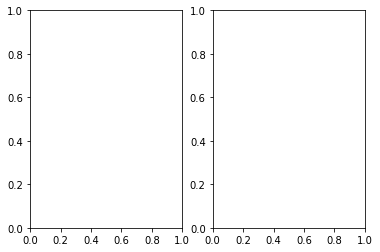

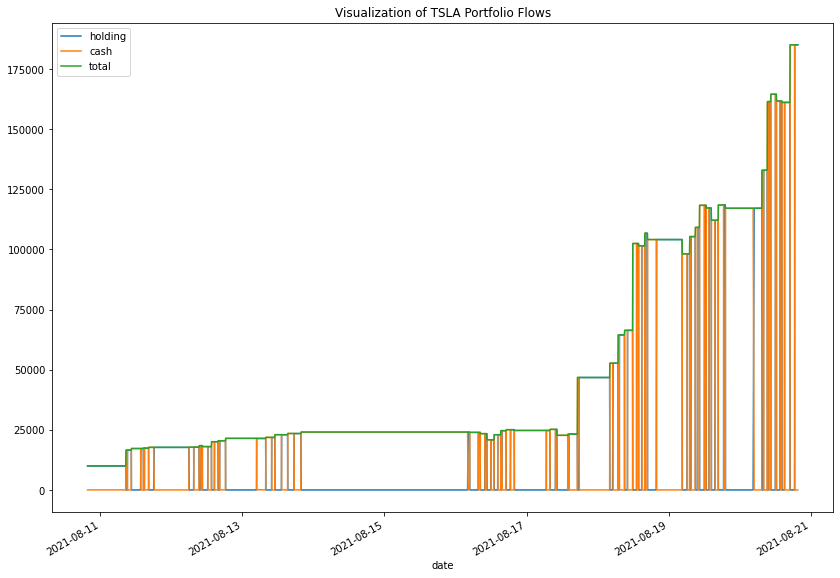

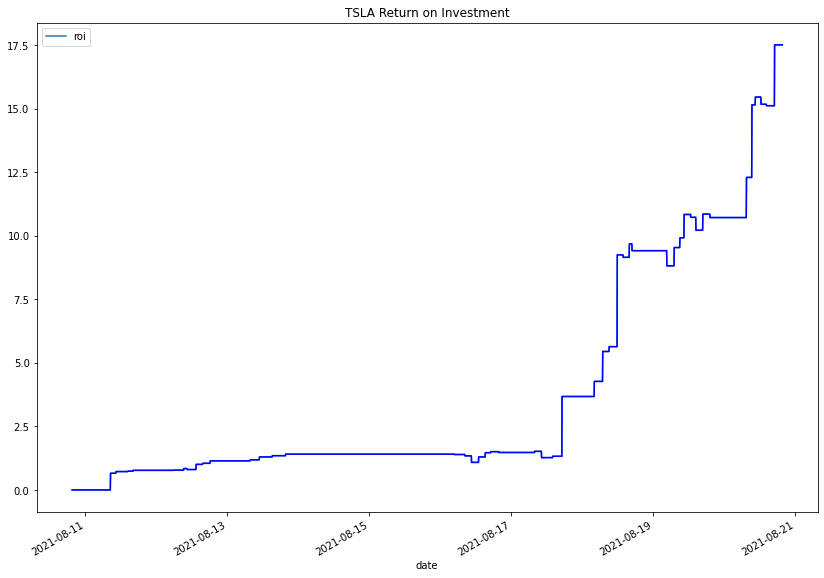

In [ ]:
SMA_predict_TSLA_Portfolio = portfolio(SMA_Signal_predict_TSLA, 'TSLA')
TSLA_predict_Portfolio = SMA_predict_TSLA_Portfolio.portfolios()
TSLA_predict_Portfolio.head()

index 23: buy 394 units at price 25.356478, current cash 9.547771, current stock 394.000000,current holding 9990.452229
index 33: sell 394 units at price 25.408819, current cash 10020.622536, current stock 0.000000,current holding 0.000000
index 44: buy 393 units at price 25.467758, current cash 11.793571, current stock 393.000000,current holding 10008.828964
index 50: sell 393 units at price 25.524426, current cash 10042.892796, current stock 0.000000,current holding 0.000000
index 56: buy 381 units at price 26.292212, current cash 25.560202, current stock 381.000000,current holding 10017.332594
index 64: sell 381 units at price 27.293974, current cash 10424.564266, current stock 0.000000,current holding 0.000000
index 70: buy 371 units at price 28.091351, current cash 2.673210, current stock 371.000000,current holding 10421.891056
index 83: sell 371 units at price 30.527458, current cash 11328.360199, current stock 0.000000,current holding 0.000000
index 86: buy 371 units at price 30

,close,signal,short_ma,long_ma,positions,cash,stock,holding,total,roi
date,,,,,,,,,,
2021-08-11 04:10:00,37.381336,0.0,37.374863,37.984670,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-11 04:15:00,35.361713,0.0,35.468493,36.459527,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-11 04:20:00,33.453629,0.0,33.643231,34.882600,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-11 04:25:00,31.747240,0.0,31.976343,33.333583,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-11 04:30:00,30.272238,0.0,30.518384,31.881322,0.0,10000.0,0.0,0.0,10000.0,0.0


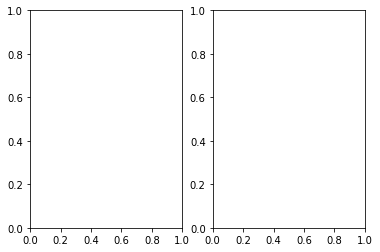

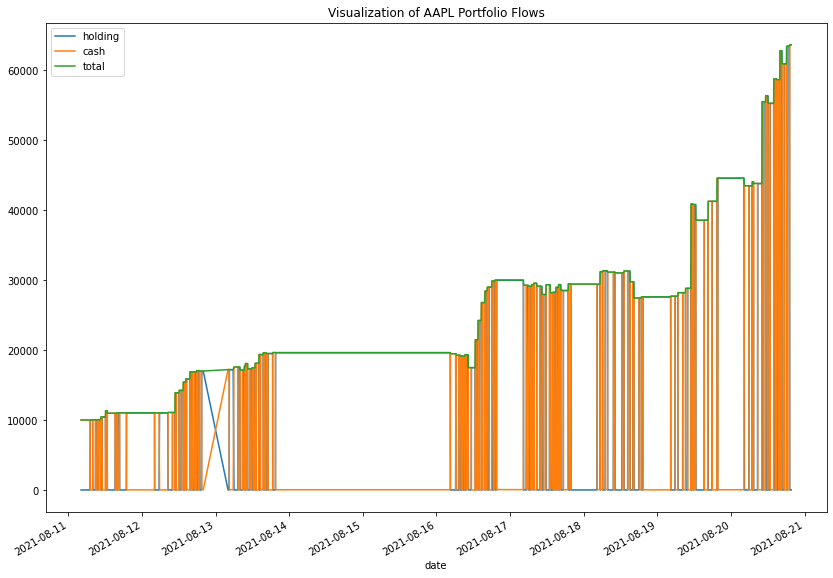

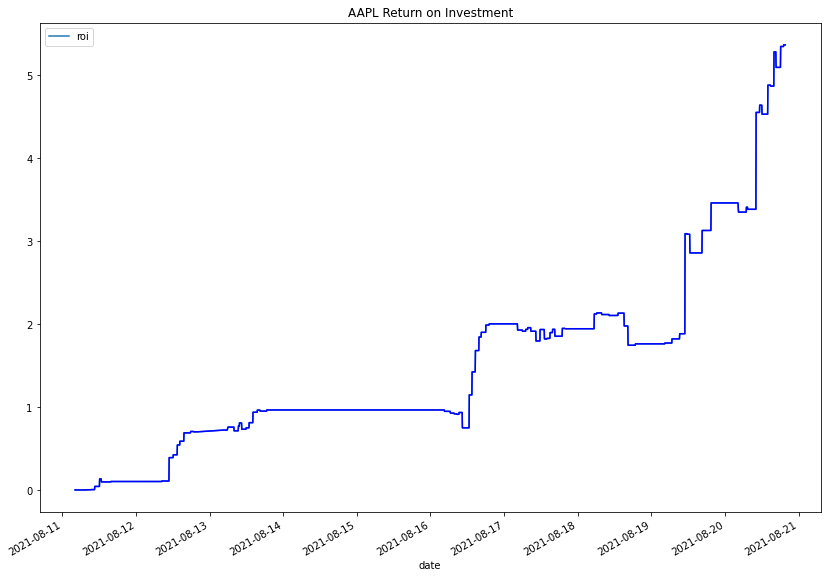

In [ ]:
SMA_predict_AAPL_Portfolio = portfolio(SMA_Signal_predict_AAPL, 'AAPL')
AAPL_predict_Portfolio = SMA_predict_AAPL_Portfolio.portfolios()
AAPL_predict_Portfolio.head()

Exponential Moving Average (EMA) is also widely used as an alternative in applying moving average strategy, given by an iterated function, with window $n$ at time $t$:

$EMA_t= \frac{2}{1+n}(p_t - EMA_{t-1}) + EMA_{t-1}, \quad t \geq 2$